# Predicting Stock Prices using Machine Learning 📈
This notebook will introduce some foundation machine learning and data science concepts by exploring the problem of regression.
It is intended to be an end-to-end example of what a data science and machine learning proof of concept might look like.

Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.
More specifically, we'll look at the following topics.

* **Exploratory data analysis (EDA)** - the process of going through a dataset and finding out more about it.
* **Model training** - create model(s) to learn to predict a target variable based on other variables.
* **Model evaluation** - evaluating a models predictions using problem-specific evaluation metrics. 
* **Model comparison** - comparing several different models to find the best one.
* **Cross-validation** - if we do build a good model, can we be sure it will work on unseen data?
* **Predicting the Test Data** - We now finally, predict the target using out traing model and the test data.

### 1. Importing required packages

In [25]:
# Regular EDA and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError, ResidualsPlot

#To get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# We want our plots to appear in the notebook
%matplotlib inline

## Models
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## 2. Data Exploration

Data can be found in `Data/` Folder. 
The ones we are going to use:


Once we have imported our data, we are going to explore and get to know about the different Attributes and their patterns with the data.

Data Exploration is one of most important tasks in Machine Learning.

In [2]:
train_data = pd.read_csv("data/Train_dataset_ - Train_Aug10.csv")
train_data.head()

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Stock Price
0,AA1,NYSE,Real Estate,700.29,12765.84,32.38,45.35,1208599.0,5.05,-0.43,0.0520,1.0,0.61,9.20,156.987852
1,AA2,NYSE,Information Tech,214.52,12765.84,33.25,170.56,13753356.0,3.10,0.23,0.0164,1.0,NaN,6.91,560.859622
2,AA3,NYSE,Information Tech,943.42,12765.84,88.27,143.58,6892003.0,7.70,0.23,0.0396,1.0,NaN,6.09,1279.732874
3,AA4,BSE,Materials,828.13,38182.08,73.66,151.76,8316793.0,4.80,0.03,0.0431,74.9,1.11,5.60,1121.787632
4,AA5,S&P 500,Real Estate,NaN,3351.28,23.79,NaN,3943312.0,8.06,-0.43,0.0244,1.0,1.07,9.46,382.962534


In [3]:
train_data.info() #Gives Insight about different Attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Stock Index           7383 non-null   object 
 1   Index                 7383 non-null   object 
 2   Industry              7383 non-null   object 
 3   VWAP                  7345 non-null   float64
 4   General Index         7321 non-null   float64
 5   NAV                   7322 non-null   float64
 6   P/E Ratio             7149 non-null   float64
 7   Volumes Traded        7115 non-null   float64
 8   Inventory Turnover    6984 non-null   float64
 9   Covid Impact (Beta)   7007 non-null   float64
 10  Tracking Error        7312 non-null   float64
 11  Dollar Exchange Rate  7306 non-null   float64
 12  Put-Call Ratio        7298 non-null   float64
 13  P/B Ratio             7358 non-null   float64
 14  Stock Price           7383 non-null   float64
dtypes: float64(12), objec

### 2.A Filling Missing Values

In [4]:
train_data.isna().sum() #Gives the number of missing values in each column

Stock Index               0
Index                     0
Industry                  0
VWAP                     38
General Index            62
NAV                      61
P/E Ratio               234
Volumes Traded          268
Inventory Turnover      399
Covid Impact (Beta)     376
Tracking Error           71
Dollar Exchange Rate     77
Put-Call Ratio           85
P/B Ratio                25
Stock Price               0
dtype: int64

By exploring the data we can observe that there are patterns between a few columns. These patterns could be used to our advantage to fill the missing values.

In [5]:
pd.crosstab(train_data['Index'],train_data['Dollar Exchange Rate'])

Dollar Exchange Rate,1.0,17.7,74.9
Index,,,
BSE,0,0,1447
JSE,0,1463,0
NSE,0,0,1484
NYSE,1454,0,0
S&P 500,1458,0,0


**Pattern 1 : Index vs. Dollar Exchange Rate**
The Dollar Exchange Rate values are depended on the Index Column.
The Dollar Exchange Rates for the following Indexes are :

*  **NSE**  : 74.9
*  **NYSE** : 1.0
*  **BSE**  : 74.9
*  **JSE**  : 17.7
*  **S&P 500**  : 1.0

In [6]:
train_data.loc[train_data["Index"]=="NSE", ["Dollar Exchange Rate"]] = 74.9
train_data.loc[train_data["Index"]=="NYSE", ["Dollar Exchange Rate"]] = 1.0
train_data.loc[train_data["Index"]=="BSE", ["Dollar Exchange Rate"]] = 74.9
train_data.loc[train_data["Index"]=="JSE", ["Dollar Exchange Rate"]] = 17.7
train_data.loc[train_data["Index"]=="S&P 500", ["Dollar Exchange Rate"]] = 1.0

**Pattern 2 : Industry vs. Covid Impact (Beta)**
The Covid Impact (Beta) values are depended on the Industru Column.
The Covid Impact (Beta) for the following Indexes are :

*  **Real Estate**  : -0.43
*  **Energy** : 0.11
*  **Healthcare**  : 0.78
*  **Materials**  : 0.03
*  **Information Tech**  : 0.23

In [7]:
pd.crosstab(train_data['Industry'],train_data['Covid Impact (Beta)'])

Covid Impact (Beta),-0.43,0.03,0.11,0.23,0.78
Industry,,,,,
Energy,0,0,1431,0,0
Healthcare,0,0,0,0,1359
Information Tech,0,0,0,1389,0
Materials,0,1445,0,0,0
Real Estate,1383,0,0,0,0


In [8]:
train_data.loc[train_data["Industry"]=="Real Estate", ["Covid Impact (Beta)"]] = -0.43
train_data.loc[train_data["Industry"]=="Energy", ["Covid Impact (Beta)"]] = 0.11
train_data.loc[train_data["Industry"]=="Healthcare", ["Covid Impact (Beta)"]] = 0.78
train_data.loc[train_data["Industry"]=="Materials", ["Covid Impact (Beta)"]] = 0.03
train_data.loc[train_data["Industry"]=="Information Tech", ["Covid Impact (Beta)"]] = 0.23

**Pattern 3 : Index vs. General Index**
The General Index values are depended on the Index Column.
The General Indexs for the following Indexes are :

*  **NSE**      : 11270.15
*  **NYSE**     : 12765.84
*  **BSE**      : 38182.02
*  **JSE**      : 55722.00
*  **S&P 500**  : 3351.28

In [9]:
pd.crosstab(train_data['Index'],train_data['General Index'])

General Index,3351.28,11270.15,12765.84,38182.08,55722.00
Index,,,,,
BSE,0,0,0,1453,0
JSE,0,0,0,0,1464
NSE,0,1485,0,0,0
NYSE,0,0,1458,0,0
S&P 500,1461,0,0,0,0


In [10]:
train_data.loc[train_data["Index"]=="NSE", ["General Index"]] = 11270.15
train_data.loc[train_data["Index"]=="NYSE", ["General Index"]] = 12765.84
train_data.loc[train_data["Index"]=="BSE", ["General Index"]] = 38182.08
train_data.loc[train_data["Index"]=="JSE", ["General Index"]] = 55722.00
train_data.loc[train_data["Index"]=="S&P 500", ["General Index"]] = 3351.28

Few colums like `Volumes Traded`, `P/E Ratio` and etc have high missing data. So below code will fill those missing values with the mean of the columns.

In [11]:
train_data["Volumes Traded"].fillna(train_data["Volumes Traded"].mean(),inplace = True)
train_data["P/E Ratio"].fillna(train_data["P/E Ratio"].mean(),inplace = True)
train_data["Inventory Turnover"].fillna(train_data["Inventory Turnover"].mean(),inplace = True)
train_data["Tracking Error"].fillna(train_data["Tracking Error"].mean(),inplace = True)
train_data["Put-Call Ratio"].fillna(train_data["Put-Call Ratio"].mean(),inplace = True)

Dropping the reamaing missing data as its not a big number 

In [12]:
train_data.dropna(inplace=True)

In [13]:
train_data.isna().sum() #Finally all the Missing Data is handled

Stock Index             0
Index                   0
Industry                0
VWAP                    0
General Index           0
NAV                     0
P/E Ratio               0
Volumes Traded          0
Inventory Turnover      0
Covid Impact (Beta)     0
Tracking Error          0
Dollar Exchange Rate    0
Put-Call Ratio          0
P/B Ratio               0
Stock Price             0
dtype: int64

In [14]:
len(train_data) #Length of the Data is 7285

7285

### 2.B Spliting Data
The Data should be splitted into **train** and **test** .
**Train** Data is uses to train the model.
**Test** Data is used to evaluate the model.

Note : This Test data is only used to validate the model. Theres another Test data which will be finnaly used to predict the Stock Prices

#### Label Encoding the Data
Before splitting the Data there is a important task to be done : **Label Encoding**

**Label Encoding** refers to converting the labels into numeric form so as to convert it into the machine-readable form.

In [15]:
le =LabelEncoder()

label = le.fit_transform(train_data["Industry"])  #Label encoded the Industry column
label1 = le.fit_transform(train_data["Index"])    #Label encoded the Index column

In [16]:
train_data.drop("Industry",axis=1,inplace=True)
train_data["Industry"] = label
#Dropped the Previous column and added new encoded column for Industry.

train_data.drop("Index",axis=1,inplace=True)
train_data["Index"] = label1
#Dropped the Previous column and added new encoded column for Index.

train_data.drop("Stock Index", axis=1, inplace=True)
#The Stock Index is dropped because its just index and not used to predict anything.

#### Splitting the Data into X & Y

Y : The Column which need to be Predicted : `Stock Price`
X : Remaing Dataset

In [17]:
X = train_data.drop("Stock Price", axis =1)
Y = train_data["Stock Price"]

In [18]:
X.head()

,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Industry,Index
0,700.29,12765.84,32.38,45.35,1208599.0,5.05,-0.43,0.0520,1.0,0.610000,9.20,4,3
1,214.52,12765.84,33.25,170.56,13753356.0,3.10,0.23,0.0164,1.0,0.944722,6.91,2,3
2,943.42,12765.84,88.27,143.58,6892003.0,7.70,0.23,0.0396,1.0,0.944722,6.09,2,3
3,828.13,38182.08,73.66,151.76,8316793.0,4.80,0.03,0.0431,74.9,1.110000,5.60,3,0
5,259.61,38182.08,10.63,153.05,19263869.0,8.04,0.03,0.0344,74.9,1.150000,5.51,3,0


In [19]:
# Spliting the Data into train and test(Validation) Data 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [20]:
x_train.shape, x_test.shape

((5828, 13), (1457, 13))

In [21]:
train_data.to_csv("cleaned_testdata.csv")
#The Data is exported for future use

## Training Our Model
We've explored the data, now we'll try to use machine learning to predict our target variable : **Stock Price**
Few best Algorithms for this problem are :
* LinearRegressor
* RidgeRegressor
* RandomForestRegressor

All of the algorithms in the Scikit-Learn library use the same functions, for training a model, `model.fit(X_train, y_train)` and for scoring a `model model.score(X_test, y_test). score()` returns the ratio of correct predictions (1.0 = 100% correct).

In [22]:
np.random.seed(36) #Seed to make our results re-producable

model1 = LinearRegression()
model1.fit(x_train,y_train)
model1.score(x_test, y_test)

0.8647715221000125

In [23]:
np.random.seed(36) #Seed to make our results re-producable

model2 = linear_model.Ridge(alpha=20)
model2.fit(x_train,y_train)
model2.score(x_test, y_test)

0.86479977258432

In [26]:
np.random.seed(42)

model3 = RandomForestRegressor()
model3.fit(x_train,y_train)
model3.score(x_test, y_test)

0.9679072809096125

#### Choosing the Right Estimator (Model)
Amoung the three above models **RanbomForestRegressor** gives us the best resuts : 96.6% Accuracy

But Accuracy alone cannot determine our decision. There are other parameters that should be checked before determining the best model.

## Evaluating & Comparing Models
Currently our models are :

**model1** : `LinearRegression()`

**model2** : `linear_model.Ridge(alpha=20)`

**model3** : `RandomForestRegressor()`


In [27]:
#Predicting values with our different models
y_pred1 = model1.predict(x_test) #Predicted Values by Model1
y_pred2 = model2.predict(x_test) #Predicted Values by Model2
y_pred3 = model3.predict(x_test) #Predicted Values by Model3

### 1. R2 Score 
**RandomForest** (model3) performed best among other models.

<AxesSubplot:>

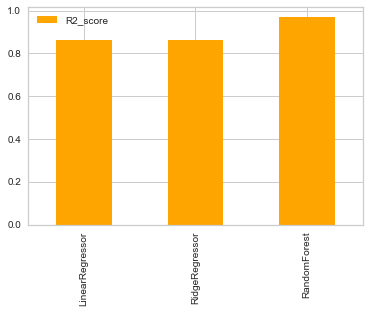

In [29]:
r2_scores = pd.DataFrame(data={"LinearRegressor":r2_score(y_test, y_pred1),
             "RidgeRegressor":r2_score(y_test, y_pred2),
             "RandomForest":r2_score(y_test, y_pred3)}, index = ["R2_score"])
r2_scores.T.plot.bar(color='orange')

### 2. Mean Absolute Error
**RandomForest** (model3) performed best among other models.

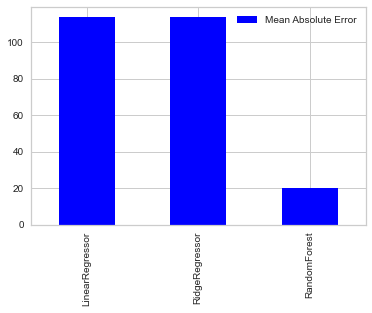

In [30]:
mae_scores = pd.DataFrame(data={"LinearRegressor":mean_absolute_error(y_test, y_pred1),
             "RidgeRegressor":mean_absolute_error(y_test, y_pred2),
             "RandomForest":mean_absolute_error(y_test, y_pred3)}, index = ["Mean Absolute Error"])
mae_scores.T.plot.bar(color='blue');

### 3. Mean Squared Error
**RandomForest** (model3) performed best among other models.

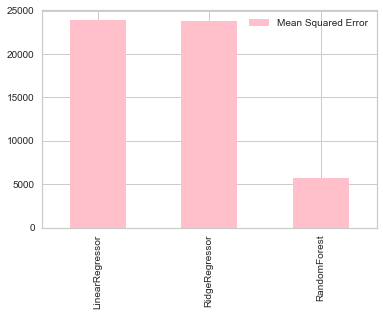

In [31]:
mse_scores = pd.DataFrame(data={"LinearRegressor":mean_squared_error(y_test, y_pred1),
             "RidgeRegressor":mean_squared_error(y_test, y_pred2),
             "RandomForest":mean_squared_error(y_test, y_pred3)}, index = ["Mean Squared Error"])
mse_scores.T.plot.bar(color='pink');

Among the three models the `RandomForestRegressor()` clearly dominates so we will be evluating on it further on.

## Evaluating Our Model

In [32]:
model = model3 #RandomForest
y_pred = y_pred3

### 1. Evaluating Values Manually
The below is a DataFrame containing the predicted and true value.

In [33]:
values = pd.DataFrame(data={"Predicted":y_pred,"Original":y_test,"Difference":y_pred-y_test})
values.head()

,Predicted,Original,Difference
709,952.337147,956.938507,-4.601360
3836,751.900014,733.785533,18.114481
2648,448.004294,452.089542,-4.085248
7189,566.869673,563.805525,3.064148
4986,198.050983,202.323292,-4.272310


### 2. Evaluating Values by Visualizer
The below Graph plots PredictionError.

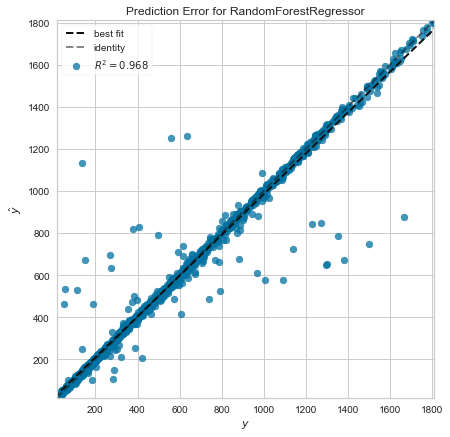

In [34]:
visualizer = PredictionError(model,size=(500,500))

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the validation data
visualizer.poof();

### 3. Evaluating using `cross_val_score`
`cross_val_score` takes different pairs of Test and Train data. And gives scores for them.

In [35]:
np.random.seed(42)

cross_val_score(model, X, Y, cv=5, scoring=None)

array([0.98629696, 0.99872824, 0.91294003, 0.99877558, 0.99420428])

In [37]:
final_test = pd.read_csv("final_test.csv")
final_test

,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Industry,Index
0,53.30,11270.15,44.59,185.09,12067855.0,2.78,0.03,0.0330,74.9,0.800000,4.66,3,2
1,749.34,55722.00,74.20,34.01,6172474.0,6.78,0.11,0.0464,17.7,0.860000,6.11,0,1
2,567.75,1461.00,88.41,177.40,17472488.0,4.36,0.23,0.0401,1.0,0.930000,4.99,2,4
3,646.78,11270.15,79.36,105.44,15553159.0,2.77,0.78,0.0187,74.9,1.090000,1.26,1,2
4,380.33,12765.84,19.90,139.40,12525784.0,5.93,0.03,0.0261,1.0,0.938828,6.18,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,965.08,55722.00,24.35,22.12,19204201.0,7.75,0.78,0.0404,17.7,0.990000,5.40,1,1
2905,175.50,11270.15,89.11,127.52,12416359.0,7.17,0.23,0.0337,74.9,1.010000,2.99,2,2
2906,121.58,11270.15,11.93,122.28,14034395.0,2.87,0.11,0.0602,74.9,0.860000,7.87,0,2
2907,479.38,38182.08,20.52,176.89,3069831.0,3.60,0.78,0.0495,74.9,0.790000,4.01,1,0


In [38]:
final_ind = pd.read_csv("final_ind.csv")

In [39]:
final_val = model.predict(final_test)

In [109]:
final_ind["Values"] = final_val
final_ind

,Index,Values
0,NSE,805.850396
1,JSE,253.370411
2,S&P 500,1567.943186
3,NSE,793.599040
4,NYSE,270.455736
...,...,...
2904,JSE,63.994186
2905,NSE,1134.567288
2906,NSE,138.278135
2907,BSE,353.790152
